In [60]:
from pandas import read_csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold,GridSearchCV,train_test_split , cross_val_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# **Dataset - Fraud Data**

In [61]:
df = pd.read_csv("/content/Fraud_check.csv")
df

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


# **Dataset - Information**

> Use decision trees to prepare a model on fraud data 
treating those who have taxable_income <= 30000 as "Risky" and others are "Good"

**Data Description :**
---

1. Undergrad : person is under graduated or not
2. Marital.Status : marital status of a person
3. Taxable.Income : Taxable income is the amount of how much tax an individual owes to the government 
4. Work Experience : Work experience of an individual person
5. Urban : Whether that person belongs to urban area or not



# **EDA**

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [63]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Taxable.Income,600.0,55208.375000,26204.827597,10003.0,32871.50,55074.5,78611.75,99619.0
City.Population,600.0,108747.368333,49850.075134,25779.0,66966.75,106493.5,150114.25,199778.0
Work.Experience,600.0,15.558333,8.842147,0.0,8.00,15.0,24.00,30.0


In [64]:
df.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [65]:
df.columns

Index(['Undergrad', 'Marital.Status', 'Taxable.Income', 'City.Population',
       'Work.Experience', 'Urban'],
      dtype='object')

In [66]:
for i in df.columns :
    print(i , '\n', df[i].value_counts())

Undergrad 
 YES    312
NO     288
Name: Undergrad, dtype: int64
Marital.Status 
 Single      217
Married     194
Divorced    189
Name: Marital.Status, dtype: int64
Taxable.Income 
 59689    2
68833    1
60822    1
93090    1
79373    1
        ..
61906    1
31088    1
70365    1
56536    1
96519    1
Name: Taxable.Income, Length: 599, dtype: int64
City.Population 
 57194     2
162777    2
50047     1
130912    1
64070     1
         ..
145744    1
58225     1
28661     1
117260    1
158137    1
Name: City.Population, Length: 598, dtype: int64
Work.Experience 
 10    31
13    28
30    25
28    25
12    25
14    24
11    23
21    23
5     22
27    22
26    22
7     21
29    21
19    21
16    19
6     19
25    19
2     19
17    18
15    18
24    17
23    16
20    15
0     14
1     14
8     14
3     14
4     14
22    13
9     13
18    11
Name: Work.Experience, dtype: int64
Urban 
 YES    302
NO     298
Name: Urban, dtype: int64


In [67]:
for col in df:
    print(f'{col}:\n {df[col].unique()}')

Undergrad:
 ['NO' 'YES']
Marital.Status:
 ['Single' 'Divorced' 'Married']
Taxable.Income:
 [68833 33700 36925 50190 81002 33329 83357 62774 83519 98152 29732 61063
 11794 61830 64070 69869 24987 39476 97957 10987 88636 14310 78969 92040
 38239 31417 55299 87778 10379 94033 73854 64007 97200 82071 12514 31336
 10163 68513 14912 74010 50777 49436 96485 70339 33614 81079 31532 44034
 16264 45706 79616 40137 97703 21917 81939 19925 34703 78573 10870 65065
 94418 26972 91684 51685 62158 58312 42507 61486 10150 99619 89302 94287
 41344 41382 32434 61105 67628 31458 73411 10329 44947 35610 66564 87348
 69098 28449 39277 13747 86652 26741 77634 99325 85651 15296 10348 41395
 22258 79583 22187 52495 93078 35072 32662 89250 41641 55873 19169 46629
 51927 69224 24557 77762 96355 90910 21945 79357 42784 54638 29944 97318
 52022 20391 21016 26679 70682 87326 15853 75501 97984 53378 93458 56501
 46955 33492 35832 12470 53981 22773 84691 50087 27877 56647 59419 26783
 79453 33962 84429 63057 43128 40

In [68]:
# find categorical and numeric variables

categorical = [var for var in df.columns if df[var].dtype=='O']
print('There are {} categorical variables\n'.format(len(categorical)))
print('The categorical variables are :\n', categorical)
print('\n')
numeric = [var for var in df.columns if df[var].dtype!='O']
print('There are {} Numeric variables\n'.format(len(numeric)))
print('The Numeric variables are :\n', numeric)

There are 3 categorical variables

The categorical variables are :
 ['Undergrad', 'Marital.Status', 'Urban']


There are 3 Numeric variables

The Numeric variables are :
 ['Taxable.Income', 'City.Population', 'Work.Experience']


In [69]:
num_columns = df.select_dtypes(exclude='object').columns.tolist()
num_data = df[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

,Taxable.Income,City.Population,Work.Experience
skewness,0.030015,0.125009,0.018529
kurtosis,-1.199782,-1.120154,-1.167524


## **Visualization**

Skew: 0.030014788906377175
Kurtosis: -1.1997824607083138


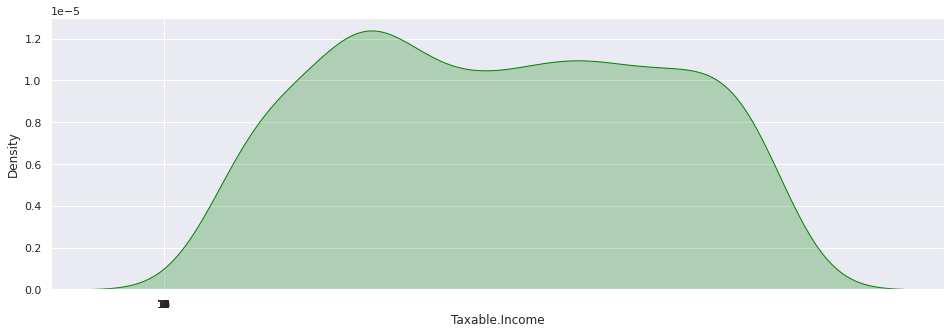

Skew: 0.12500898782679504
Kurtosis: -1.1201539229184019


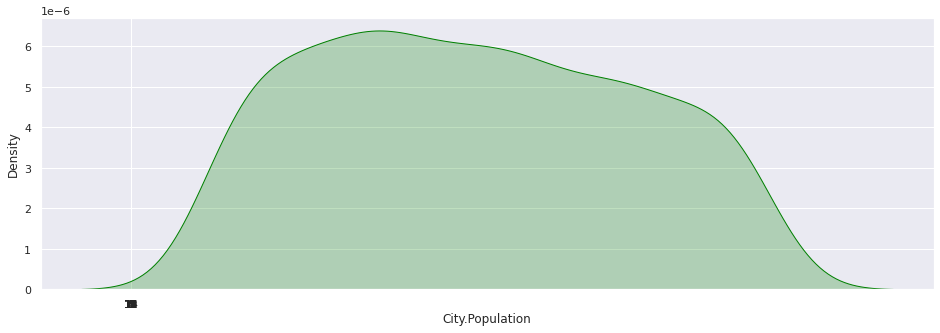

Skew: 0.01852862786533781
Kurtosis: -1.1675237113768457


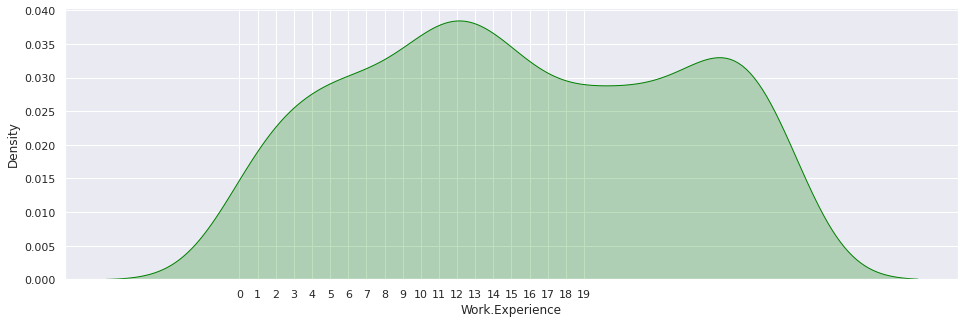

In [70]:
for i in numeric:
  plt.figure(figsize=(16,5))
  print("Skew: {}".format(df[i].skew()))
  print("Kurtosis: {}".format(df[i].kurtosis()))
  ax = sns.kdeplot(df[i],shade=True,color='g')
  plt.xticks([i for i in range(0,20,1)])
  plt.show()


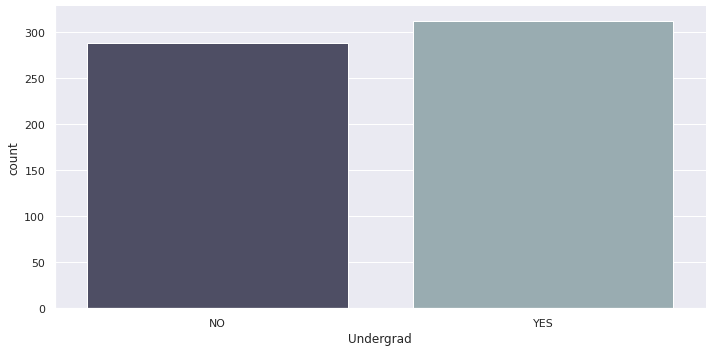

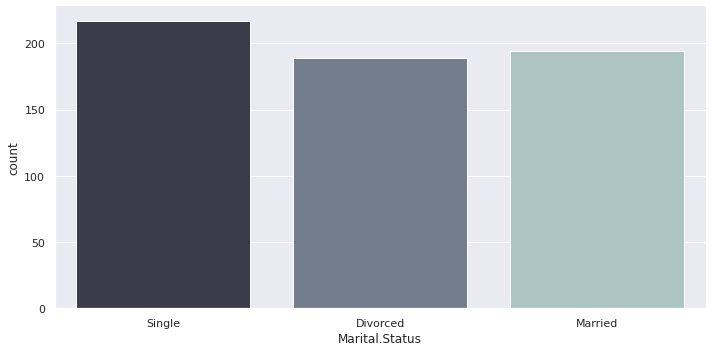

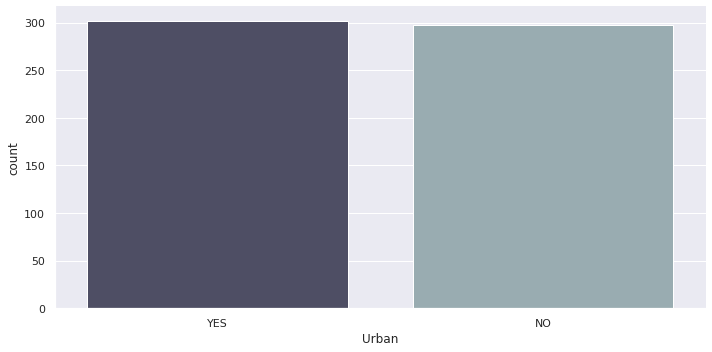

In [71]:
for i in categorical:
  sns.catplot(i, data=df, kind="count",height = 5,aspect = 2, palette="bone")
  

<Figure size 432x288 with 0 Axes>

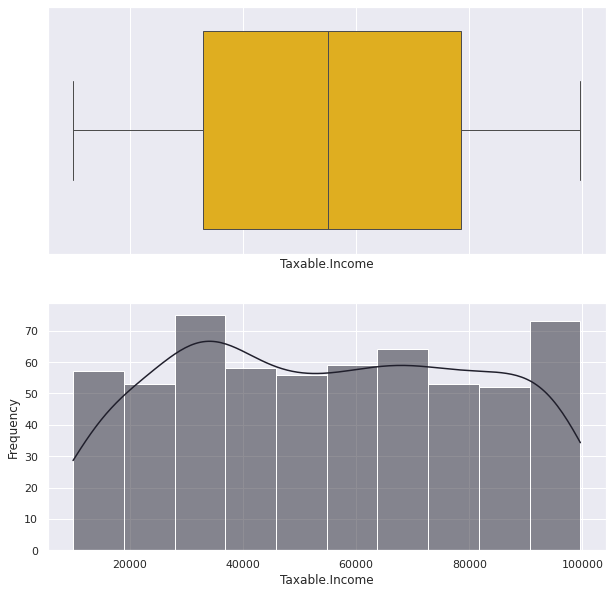

<Figure size 720x720 with 0 Axes>

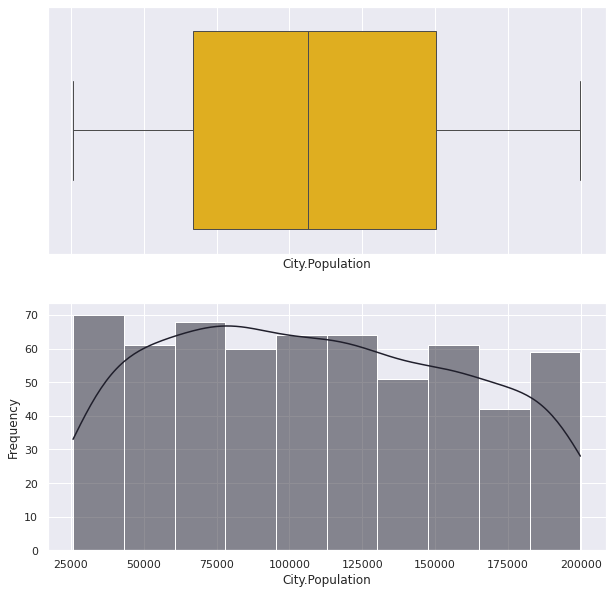

<Figure size 720x720 with 0 Axes>

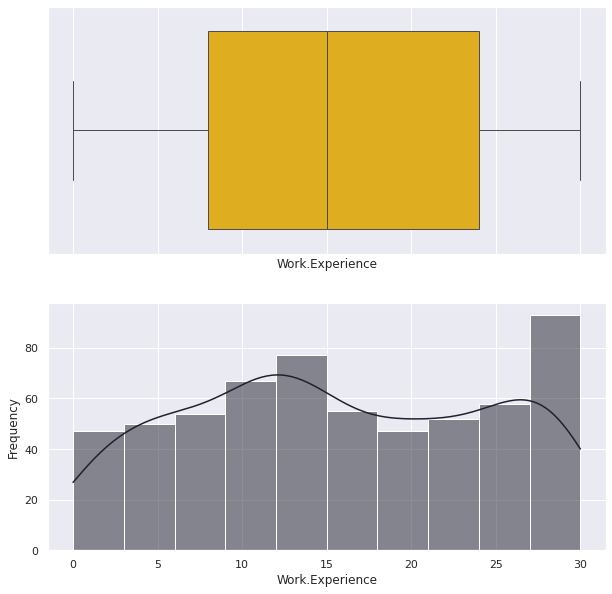

In [72]:
for i in numeric:
    plt.figure()
    plt.tight_layout()
    sns.set(rc={"figure.figsize":(10, 10)}, palette="bone")
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
    plt.gca().set(xlabel= i,ylabel='Frequency')
    sns.boxplot(df[i], ax=ax_box , linewidth= 1.0, palette="Wistia_r")
    sns.histplot(df[i], ax=ax_hist , bins = 10,kde=True, palette="Wistia_r")

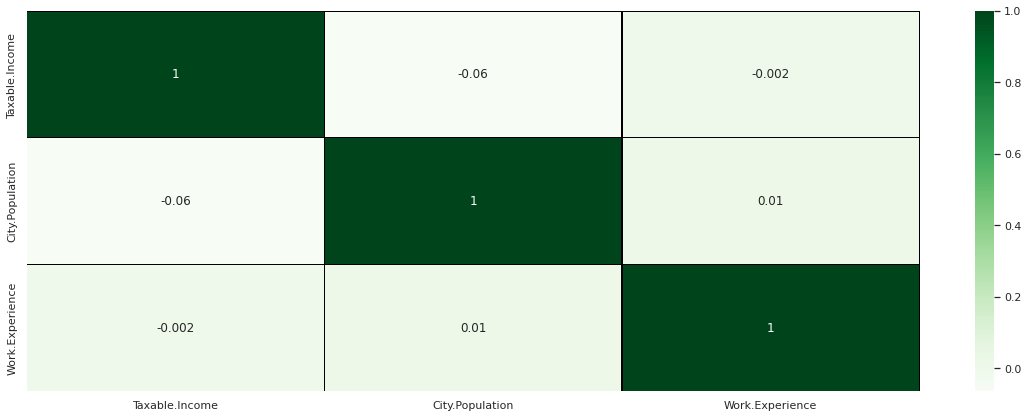

In [73]:
plt.figure(figsize=(20,7))
# plotting correlation heatmap
dataplot = sns.heatmap(df.corr(), cmap="Greens", annot=True, linecolor='black', linewidths=0.5, fmt='.1g')
  
# displaying heatmap
plt.show()

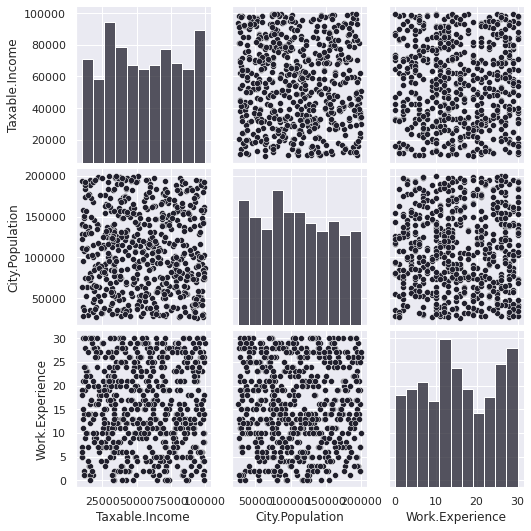

In [74]:
#pairwise plot of all the features
sns.pairplot(df)
plt.show()

# **Random Forest**

## **Encoding Dependent Variable**

In [75]:
df['Taxable.Income'] = np.where( df['Taxable.Income'] <= 30000, 1, 0)
df

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,0,50047,10,YES
1,YES,Divorced,0,134075,18,YES
2,NO,Married,0,160205,30,YES
3,YES,Single,0,193264,15,YES
4,NO,Married,0,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,0,39492,7,YES
596,YES,Divorced,0,55369,2,YES
597,NO,Divorced,0,154058,0,YES
598,YES,Married,0,180083,17,NO


In [76]:
df['Taxable.Income'].value_counts()

0    476
1    124
Name: Taxable.Income, dtype: int64

### **One-Hot encoding for categorical variable**

In [77]:
### Applying encoding for catogorical Data

from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder(handle_unknown="ignore", sparse=False)

data=df.copy()

columns1=['Undergrad','Marital.Status','Urban']


for i in columns1:
   x=pd.DataFrame(ohe.fit_transform(data[[i]]), columns=data[i].unique())
   data = pd.concat([x,data], axis=1, join="inner").drop(i,axis=1)


data


,YES,NO,Single,Divorced,Married,NO,YES,Taxable.Income,City.Population,Work.Experience
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0,50047,10
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0,134075,18
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,160205,30
3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0,193264,15
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,27533,28
...,...,...,...,...,...,...,...,...,...,...
595,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0,39492,7
596,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0,55369,2
597,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0,154058,0
598,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0,180083,17


## **Scalling Data**

In [78]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)
scaled_data

array([[0.        , 1.        , 0.        , ..., 0.        , 0.13947207,
        0.33333333],
       [0.        , 1.        , 1.        , ..., 0.        , 0.62239438,
        0.6       ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.77256766,
        1.        ],
       ...,
       [0.        , 1.        , 1.        , ..., 0.        , 0.73723987,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.88680969,
        0.56666667],
       [1.        , 0.        , 1.        , ..., 0.        , 0.76068253,
        0.53333333]])

In [79]:
scaled_data=pd.DataFrame(scaler.fit_transform(data),columns=data.columns, index=data.index)
scaled_data

,YES,NO,Single,Divorced,Married,NO,YES,Taxable.Income,City.Population,Work.Experience
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.139472,0.333333
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.622394,0.600000
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.772568,1.000000
3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.962563,0.500000
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.010081,0.933333
...,...,...,...,...,...,...,...,...,...,...
595,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.078811,0.233333
596,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.170058,0.066667
597,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.737240,0.000000
598,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.886810,0.566667


In [80]:
x_data=scaled_data.drop(['Taxable.Income'], axis=1)
y_data=scaled_data["Taxable.Income"]
x_data

,YES,NO,Single,Divorced,Married,NO,YES,City.Population,Work.Experience
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.139472,0.333333
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.622394,0.600000
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.772568,1.000000
3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.962563,0.500000
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.010081,0.933333
...,...,...,...,...,...,...,...,...,...
595,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.078811,0.233333
596,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.170058,0.066667
597,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.737240,0.000000
598,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.886810,0.566667


In [81]:
scaled_data["Taxable.Income"].value_counts()

0.0    476
1.0    124
Name: Taxable.Income, dtype: int64

* **Here the data is imbalanced ,so for balancing here we use SMOTE to resample the data.**

In [82]:
x= np.array(x_data)
y= np.array(y_data)

In [83]:
import imblearn
from imblearn.over_sampling import SMOTE
over_sampler = SMOTE(random_state=42)
X_res, y_res = over_sampler.fit_resample(x, y)

In [84]:
# Splitting data into training and testing data set
x_train, x_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.30, random_state=42)

In [85]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(666, 9)
(286, 9)
(666,)
(286,)


In [86]:
pd.Series(y_test).value_counts()

0.0    146
1.0    140
dtype: int64

## **Model Building - Random Forest**

In [87]:
rfc = RandomForestClassifier(bootstrap=True,n_estimators = 12 ,max_depth=5 , random_state = 42)
rfc.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=12, random_state=42)

DecisionTreeClassifier(max_depth=5, max_features='auto',
                       random_state=1608637542)


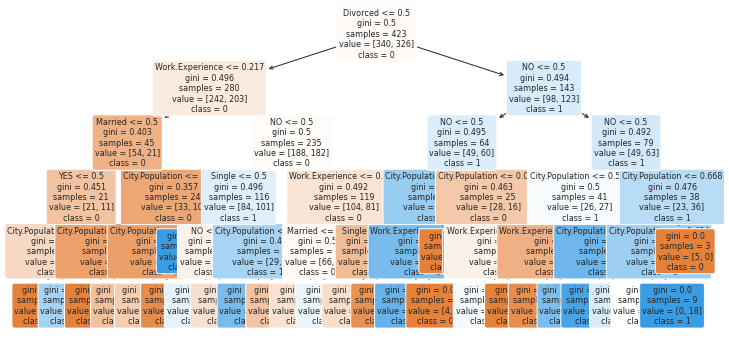

DecisionTreeClassifier(max_depth=5, max_features='auto',
                       random_state=1273642419)


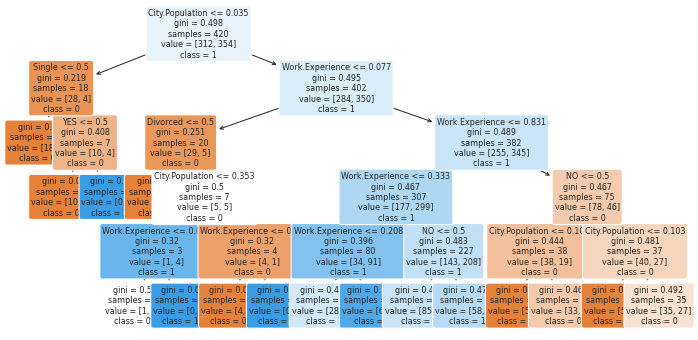

DecisionTreeClassifier(max_depth=5, max_features='auto',
                       random_state=1935803228)


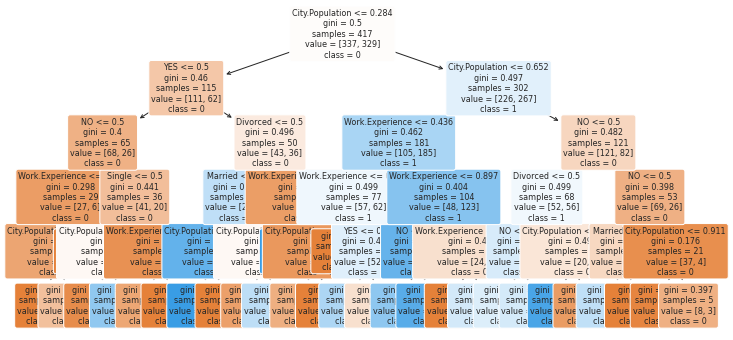

DecisionTreeClassifier(max_depth=5, max_features='auto', random_state=787846414)


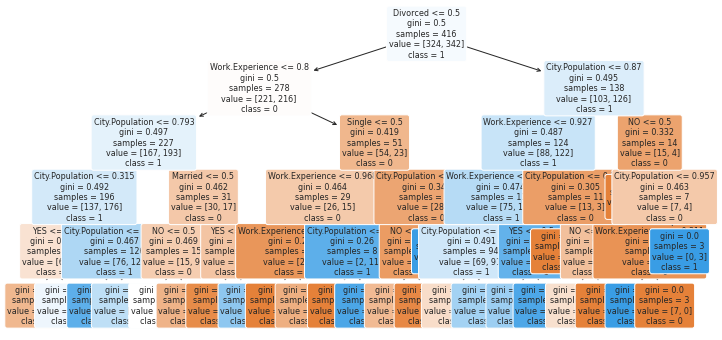

DecisionTreeClassifier(max_depth=5, max_features='auto', random_state=996406378)


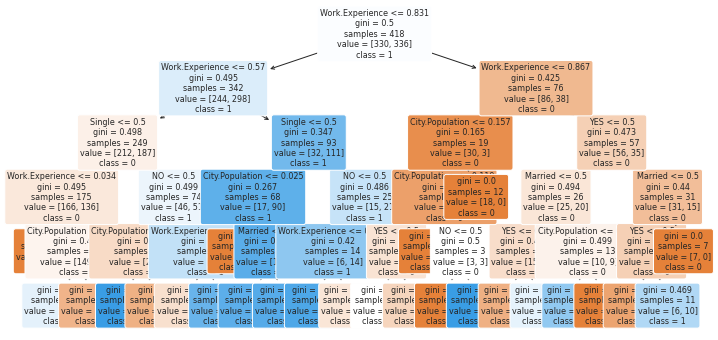

DecisionTreeClassifier(max_depth=5, max_features='auto',
                       random_state=1201263687)


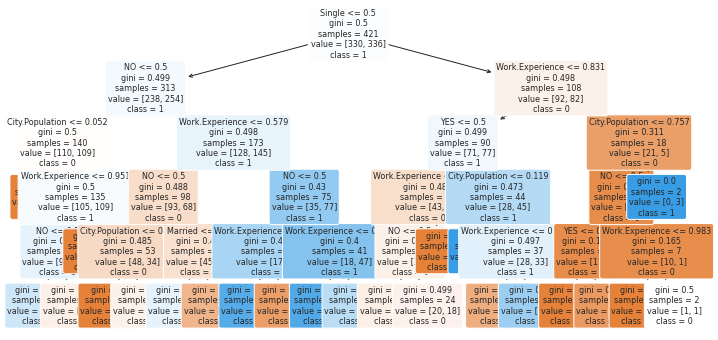

DecisionTreeClassifier(max_depth=5, max_features='auto', random_state=423734972)


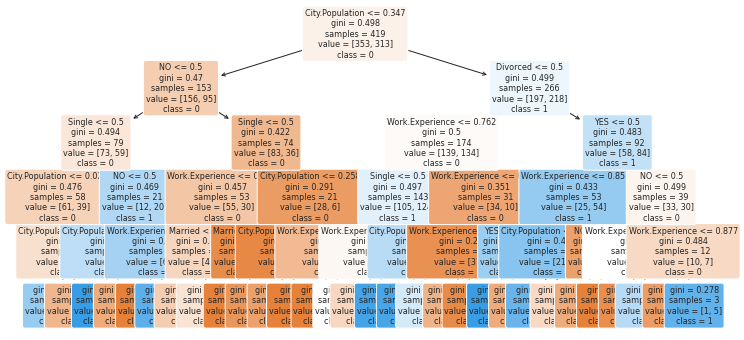

DecisionTreeClassifier(max_depth=5, max_features='auto', random_state=415968276)


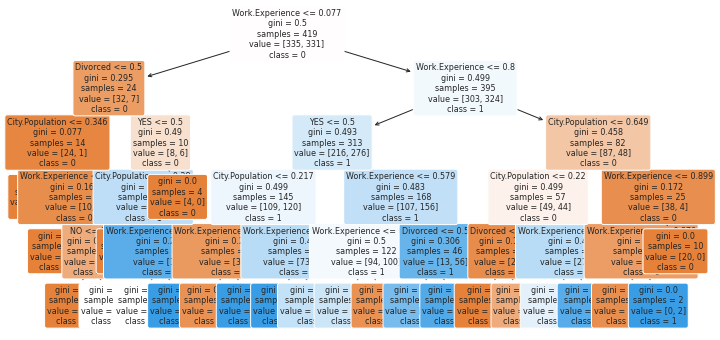

DecisionTreeClassifier(max_depth=5, max_features='auto', random_state=670094950)


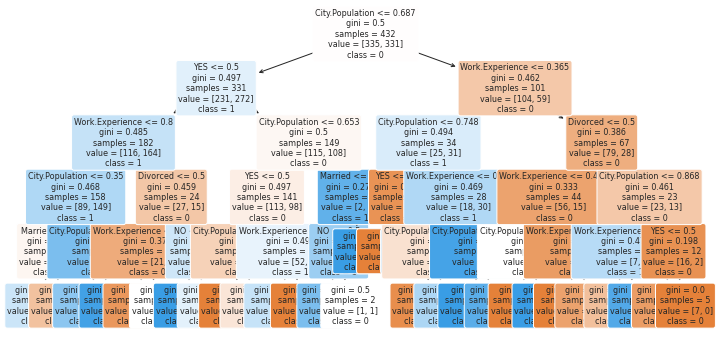

DecisionTreeClassifier(max_depth=5, max_features='auto',
                       random_state=1914837113)


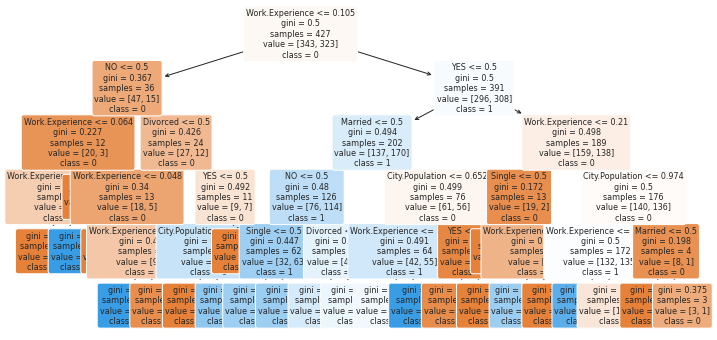

DecisionTreeClassifier(max_depth=5, max_features='auto', random_state=669991378)


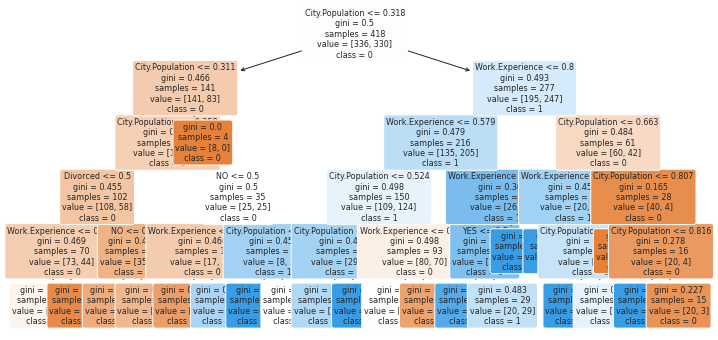

DecisionTreeClassifier(max_depth=5, max_features='auto', random_state=429389014)


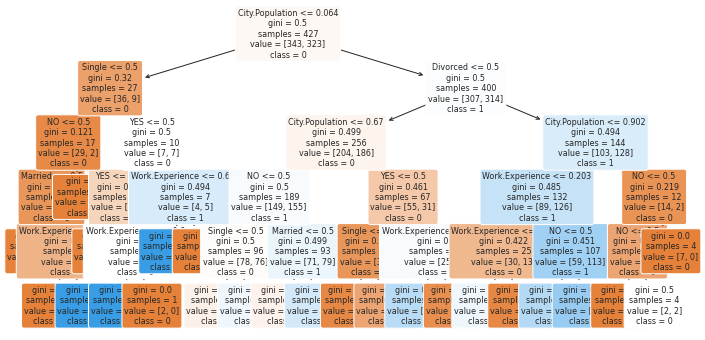

In [88]:
from sklearn import tree

features = x_data.columns.values # The name of each column
classes = ['0', '1', '2'] # The name of each class
# You can also use low, medium and high risks in the same order instead
# classes = ['low risk', 'medium risk', 'high risk']

for estimator in rfc.estimators_:
    print(estimator)
    plt.figure(figsize=(12,6))
    tree.plot_tree(estimator,
                   feature_names=features,
                   class_names=classes,
                   fontsize=8, 
                   filled=True, 
                   rounded=True)
    plt.show()

In [89]:
# Predict the test set labels
y_pred = rfc.predict(x_test)
pd.Series(y_pred).value_counts()

1.0    151
0.0    135
dtype: int64

              precision    recall  f1-score   support

         0.0       0.64      0.60      0.62       146
         1.0       0.61      0.66      0.63       140

    accuracy                           0.63       286
   macro avg       0.63      0.63      0.63       286
weighted avg       0.63      0.63      0.63       286



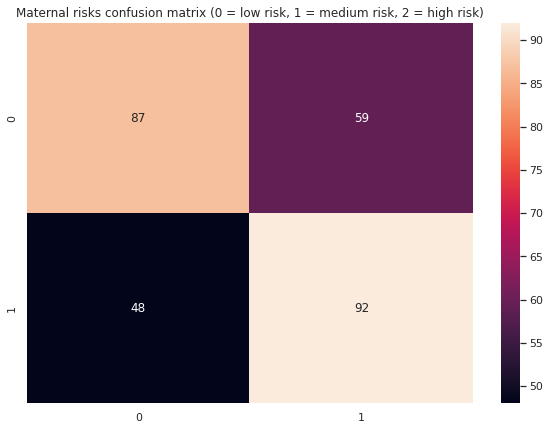

In [90]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d').set_title('Maternal risks confusion matrix (0 = low risk, 1 = medium risk, 2 = high risk)')

print(classification_report(y_test,y_pred))

In [91]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(rfc.score(x_train, y_train)))

print('Test set score: {:.4f}'.format(rfc.score(x_test, y_test)))

Training set score: 0.7538
Test set score: 0.6259


In [92]:
df1 = pd.DataFrame({'actual': y_test, 'Entro_Prediction': y_pred})
df1.head()

,actual,Entro_Prediction
0,1.0,1.0
1,0.0,0.0
2,1.0,0.0
3,1.0,0.0
4,0.0,0.0


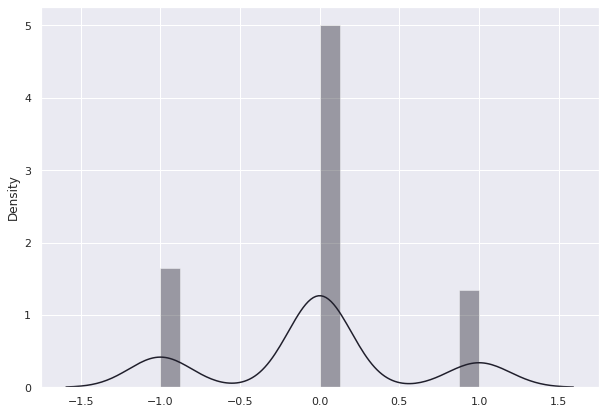

In [93]:
# checking difference between labled y and predicted y
plt.figure(figsize = (10,7))
sns.distplot(y_test-y_pred)

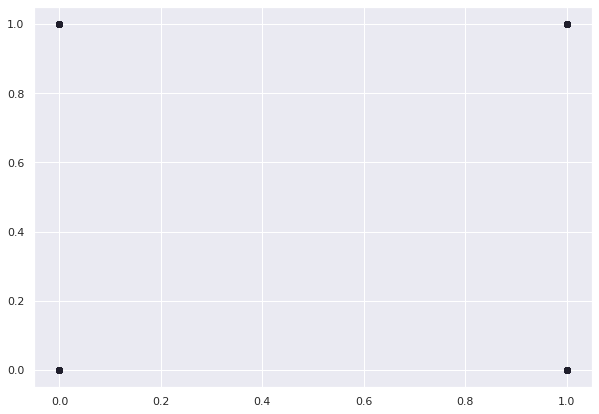

In [94]:
plt.figure(figsize = (10,7))
plt.scatter(y_test,y_pred)

In [95]:
# print the scores between dependent test and predicted value

print("Accuracy_score", accuracy_score(y_test,y_pred)*100)

Accuracy_score 62.58741258741259




 ROC AUC score: 0.6265166340508805 




Text(0, 0.5, 'True Positive Rate')

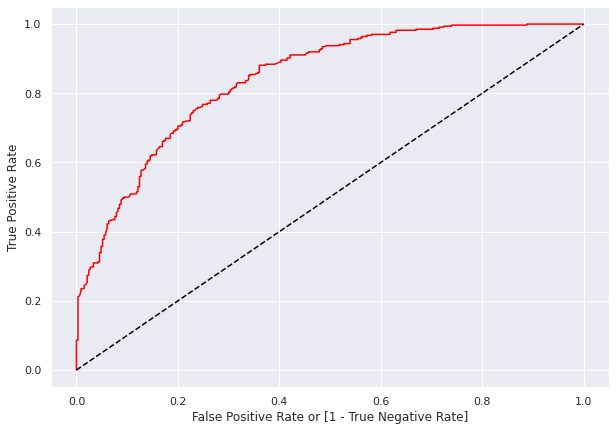

In [96]:
# plot ROC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train, rfc.predict_proba (x_train)[:,1])

auc = roc_auc_score(y_test, y_pred)

plt.figure(figsize= (10,7))

plt.plot(fpr, tpr, color='red', label='logit model ( area  = %0.2f)'%auc)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')

print(f'\n\n ROC AUC score: {auc} \n\n')
plt.ylabel('True Positive Rate')

## **Feature Importance:**

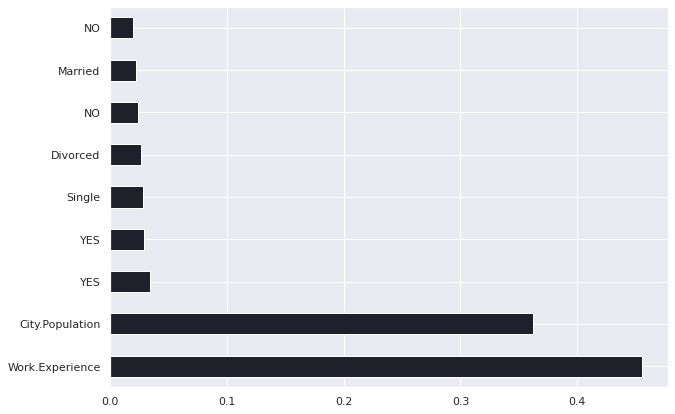

In [97]:
feat_importances = pd.Series(rfc.feature_importances_, index=x_data.columns)
plt.figure(figsize = (10,7))
feat_importances.nlargest(20).plot(kind='barh')